TODO Poner la cobertura de genes (muy pocos representados en el ME model)  
Titulos en ingles

In [1]:
# Energy from the ME model

In [ ]:
import re
import pickle
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt

# Own modules for analysis
from energy_analisis import get_energy_consumption_production, energy_per_model, get_energy_per_gene
from plot_energy import plot_ME_energy, plot_glc_ox_atp

In [3]:
# load solved ME model
with open('../files/models/iJL1678b_solver.pickle', 'rb') as f:
    me = pickle.load(f)

# ATP consumption per reaction 

In [4]:
# Get the consumption and production of energy per reaction
reactions_energy_consumption,reactions_energy_production = get_energy_consumption_production(me)

In [5]:
energy_consumption = pd.DataFrame.from_dict(reactions_energy_consumption).set_index('Reactions')
energy_consumption.head()

,Type,Total,Used,ATP
Reactions,,,,
transcription_TU0_8529_from_RpoD_mono,TranscriptionReaction,-347.0,-3.988197e-09,-347.0
transcription_TU0_8464_from_RpoD_mono,TranscriptionReaction,-88.0,-2.039023e-04,-88.0
transcription_TU0_13006_from_RpoD_mono,TranscriptionReaction,-172.0,-5.661036e-12,-172.0
transcription_TU0_5003_from_RPOH_MONOMER,TranscriptionReaction,-434.0,-1.200694e-07,-434.0
transcription_TU0_3423_from_RPOE_MONOMER,TranscriptionReaction,-109.0,-3.812990e-06,-109.0


In [6]:
energy_production = pd.DataFrame.from_dict(reactions_energy_production).set_index('Reactions')
energy_production.head()

,Type,Total,Used,ATP
Reactions,,,,
ATPS4rpp_FWD_ATPSYN-CPLX_mod_mg2,MetabolicReaction,1.0,52.367990,1.0
NDPK1_FWD_ADENYL-KIN-MONOMER_mod_mg2,MetabolicReaction,-1.0,-9.991650,-1.0
PGK_REV_PGK-CPLX,MetabolicReaction,1.0,12.566816,1.0
PPK2r_REV_PPK-CPLX,MetabolicReaction,1.0,0.000097,1.0
SUCOAS_REV_SUCCCOASYN,MetabolicReaction,1.0,3.955319,1.0


In [7]:
total_produced = energy_production.sum().Used
total_produced

58.8985714173988

In [8]:
# Save file
energy_consumption.to_pickle('../files/energy/energy_per_reaction.pickle')

In [9]:
with open('../files/energy/energy_per_reaction.pickle', 'rb') as f:
    energy_consumption = pickle.load(f)

In [10]:
energy_consumption.loc[:,'Used'] = abs(energy_consumption.Used)
energy_consumption.head()

,Type,Total,Used,ATP
Reactions,,,,
transcription_TU0_8529_from_RpoD_mono,TranscriptionReaction,-347.0,3.988197e-09,-347.0
transcription_TU0_8464_from_RpoD_mono,TranscriptionReaction,-88.0,2.039023e-04,-88.0
transcription_TU0_13006_from_RpoD_mono,TranscriptionReaction,-172.0,5.661036e-12,-172.0
transcription_TU0_5003_from_RPOH_MONOMER,TranscriptionReaction,-434.0,1.200694e-07,-434.0
transcription_TU0_3423_from_RPOE_MONOMER,TranscriptionReaction,-109.0,3.812990e-06,-109.0


# ATP consumption per gene

In [11]:
total = get_energy_per_gene(energy_consumption, me)

In [12]:
Energia_total_ME = pd.DataFrame(total.items(), columns=['Bnumber', 'Value'])
Energia_total_ME = Energia_total_ME.sort_values(by='Value',ascending=False).reset_index()
Energia_total_ME = Energia_total_ME.loc[:,['Bnumber','Value']]

In [13]:
Energia_total_ME.to_pickle('../files/energy/energy_per_gene.pickle')

In [14]:
Energia_total_ME.head()

,Bnumber,Value
0,b3256,22.337696
1,dummy,1.671482
2,b2752,0.977113
3,b1677,0.232208
4,b0727,0.194296


# ATP consumption (Strains)

In [15]:
names_W3110 = ['DGF298', 'DGF327', 'MGF02', 'MGF01' ]
names_MG1655 = ['Δ16', 'MS56', 'MDS69','MDS42','MDS12']
strains = names_MG1655+names_W3110

genes_finales = {}

for strain in strains:
    genes_finales[strain] = pd.read_csv('../files/deleted_genes/mapped_del_genes_'+strain+'.csv')
    genes_finales[strain] = genes_finales[strain].drop(columns= 'Unnamed: 0')

#### Per gene

In [16]:
strain_energy_per_gen={}
for strain in strains:
    genes = genes_finales[strain].Bnumber
    strain_energy_per_gen[strain] = Energia_total_ME.loc[Energia_total_ME.Bnumber.isin(genes)]

#### Per strain

In [17]:
strain_energy_total={}
for strain in strains:
    strain_energy_total[strain] = [strain_energy_per_gen[strain].Value.sum()]
    
strain_energy_total_per={}
for strain in strains:
    strain_energy_total_per[strain] = [(strain_energy_per_gen[strain].Value.sum()*100)/(total_produced)]

In [18]:
consumo = pd.DataFrame.from_dict(strain_energy_total)
consumo = consumo.T.rename(columns={0:'Energy'}).T
consumo_per =  pd.DataFrame.from_dict(strain_energy_total_per)
consumo_per = consumo_per.T.rename(columns={0:'Energy'}).T

In [19]:
consumo

,Δ16,MS56,MDS69,MDS42,MDS12,DGF298,DGF327,MGF02,MGF01
Energy,0.788286,0.172213,0.167337,0.163238,0.163234,0.174018,0.168425,0.004769,0.003504


In [20]:
relevant_strains = ['Δ16', 'MS56', 'MDS69', 'DGF298', 'MGF02']

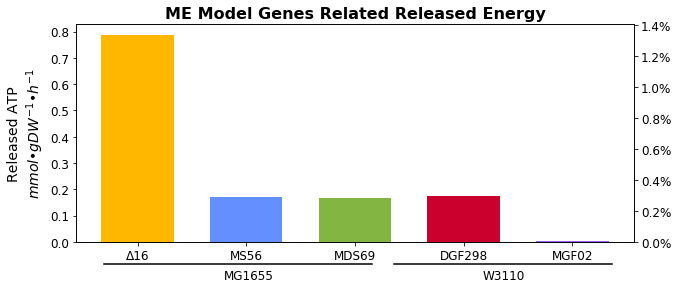

In [21]:
plot_ME_energy(relevant_strains,consumo, consumo_per )

# Energy analysis for each process

#### Replication 

In [22]:
replication_models = ['1', '1.125', '1.25', '1.5']
models = {}

for rep_model in replication_models:
    with open('../files/models/DNA_per'+rep_model+'.pickle', 'rb') as f:
        models[rep_model] = pickle.load(f)

In [23]:
models

{'1': <MEModel iJL1678b-ME at 0x7fce71b83eb8>,
 '1.125': <MEModel iJL1678b-ME at 0x7fce71bde160>,
 '1.25': <MEModel iJL1678b-ME at 0x7fce71bf54a8>,
 '1.5': <MEModel iJL1678b-ME at 0x7fce71bdeeb8>}

In [24]:
consumption_me,p = energy_per_model(models)

In [25]:
consumption_me

{'me1': 48.83228748371048,
 'me1.125': 48.842039251079456,
 'me1.25': 48.85179103734148,
 'me1.5': 48.87129454230218}

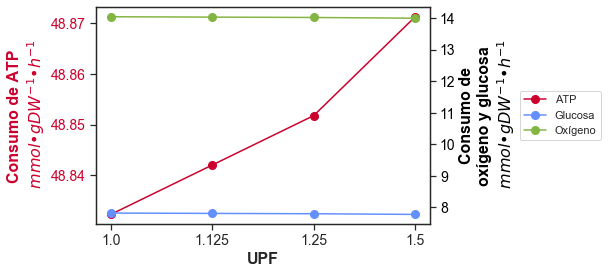

In [26]:
plot_glc_ox_atp(consumption_me, models)

In [28]:
valores = [1, 1.125, 1.25, 1.5]
new_valores = np.array(valores)

equivalentes_genoma = new_valores*1.63 
equivalentes_genoma
bp = equivalentes_genoma*4641652/1.63
Mb = bp*1/(1*10**6)

In [29]:
slope, intercept, r_value, p_value, std_err = stats.linregress(Mb, list(consumption_me.values()))

In [30]:
slope

0.016807404105231676

#### Transcription 

In [31]:
extra_genes = ['230', '460', '690', '920']
extra_genes_int = [int(genes) for genes in extra_genes]
transcription_models = {}
solutions = []

for gene in extra_genes:
    with open('../files/models/AumGenes_GLC_OX_'+gene+'.pickle', 'rb') as f:
        model = pickle.load(f)
        model.name = gene
        transcription_models[gene]= model
        solutions.append(model.solution.f)
    


In [33]:
consumption_me_trn, consumption_me_group, p = energy_per_model(transcription_models, group=True)

In [34]:
consumption_me_trn

{'me230': 51.77917211144516,
 'me460': 54.70214019240527,
 'me690': 57.625234172573656,
 'me920': 60.54832815274208}

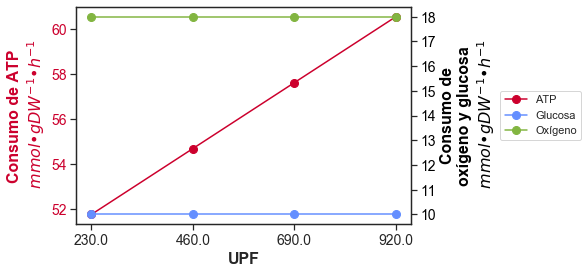

In [35]:
plot_glc_ox_atp(consumption_me_trn, transcription_models)

In [38]:
slope, intercept, r_value, p_value, std_err = stats.linregress(extra_genes_int, [consumption_me_trn['me'+genes] for genes in extra_genes])
costo_Mb = (10**6 )* slope / 900
costo_Mb

14.12104449471456

In [39]:
consumption_transR = {}
for genes in consumption_me_group:
    consumption_transR[genes] = consumption_me_group[genes].loc['TranscriptionReaction']

In [ ]:
consumption_transR

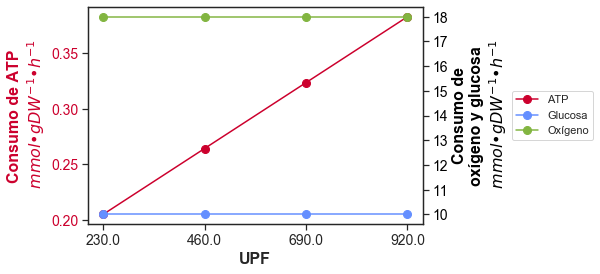

In [40]:
plot_glc_ox_atp(consumption_transR, transcription_models)

In [41]:
slope_2, intercept_2, r_value, p_value, std_err = stats.linregress(extra_genes_int,
                                                                   [consumption_transR['me'+genes] for genes in extra_genes])

costo_Mb_2 = (10**6 )* slope_2 / 900
costo_Mb_2

0.28688808644166874

#### UPF

In [ ]:
plot_glc_ox_atp(consumption_transR, transcription_models)